# CS576 Assignment #3: Object Detection Using YOLO v1
---
Primary TA : 
* Jaehoon Yoo (wogns98@kaist.ac.kr)
* Whie Jung (whieya@kaist.ac.kr)
---

## Instruction
- In this assignment, you will implement, train, and test Yolo v1 on Pascal VOC Detection dataset with 20 object categories (`'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'`).

- For this, you need to implement (1) architecture, (2) loss function, (3) training/testing pipeline, and (4) inference function.

- In each part, you will be given a starter code for the implementation. Please read instructions carefully to implement the codes.  

- In this assignment, we will provide you with pre-trained weights of the Yolo architecture to reduce the amount of time required for the convergence and thus ease your burden on the training. This pre-trained weights will automatically loaded to your network if you implemented it correctly.

- <font color="red"> It takes at least 6 mins per epoch, so you need at least 6*50=300 mins for the whole training. So please get started as early as possible. </font> 



## Submission guidelines
- Your code and report will be all in Colab. 
- Go to the [link](https://drive.google.com/drive/folders/1QboYl5LfKPXTijS_Cmt_UyHMMZlFzJUo?usp=sharing), make a copy of `assignment3.ipynb`, `data.py`, `dataset.zip`, `test_images.zip`, and make `weights` directory into your own google drive. Find the copies in your drive, recover their names to original ones if their names were changed to e.g. `Copy of assignment3.ipynb` or `assignment3.ipynb의 사본`. Also, keep them in a single directory.
- <font color="red"> You will get the full credit **only if** you complete the code **and** write a discussion of the results in the discussion section at the bottom of this page. Please refer to the discussion section for the details. </font> 
- We should be able to reproduce your results using your code. Please double-check if your code runs without error and reproduces your results. Submissions failed to run or reproduce the results will get a substantial penalty. 

## Deliverables
- Your Colab notebook with name of **[StudentID].ipynb**
- Result images (`1_result.jpg`, `2_result.jpg`, ...). Please refer to Problem 4.
- Saved checkpoint (`last.pth`). This will be saved automatically in your `checkpoints` directory. 
- Submit all of them in a format as : **[StudentID].zip**.
- **If your submission doesn't contain all of the above deliverables , you will lose a point for deliverable (5pt).**
- Your assignment should be submitted through KLMS. All other submissions (e.g., via email) will not be considered as valid submissions.


## Due date
- **23:59:59 June 2nd.**
- Late submission is allowed until 23:59:59 June 4th.
- Late submission will be applied 20% penalty.

## Questions
- Please use QnA board in KLMS as a main communication channel. When you post questions, please make it public so that all students can share the information. Please use the prefix "[Assignment 3]" in the subject for all questions regarding this assignment (e.g., [Assignment 3] Regarding the grading policy).

## Plagiarism
- <font color="red"> Do not copy public codes or your classmate's code. We will strictly detect the plagiarism. All codes with plagiarism will be considered as 0 point.

## Changelog

- None

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
# Specify the directory path where `assignemnt3.ipynb` and `dataset.zip` exist.
# For example, if you saved `assignment3.ipynb` `/gdrive/My Drive/cs576/assignment3` directory,
# then set root = '/gdrive/My Drive/cs576/assignment3'
root = '/gdrive/My Drive/cs576/assignment3'

!ln -s '/gdrive/My Drive'/{root.replace('/gdrive/My Drive/', '')}/weights ./
!unzip -q '/gdrive/My Drive'/{root.replace('/gdrive/My Drive/', '')}/dataset.zip
!unzip -q '/gdrive/My Drive'/{root.replace('/gdrive/My Drive/', '')}/test_images.zip

In [3]:
import sys
sys.path.append(root)

import warnings
warnings.filterwarnings("ignore")

import os
import cv2
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms

from data import VOCDetection
def makedirs(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [4]:
# Configurations
run_name = 'vgg16'          # experiment name.
ckpt_root = 'checkpoints'   # from/to which directory to load/save checkpoints.
data_root = 'dataset'       # where the data exists.
pretrained_backbone_path = 'weights/vgg_features.pth'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.001          # learning rate
batch_size = 64     # batch_size
last_epoch = 1      # the last training epoch. (defulat: 1)
max_epoch = 50     # maximum epoch for the training.

num_boxes = 2       # the number of boxes for each grid in Yolo v1.
num_classes = 20    # the number of classes in Pascal VOC Detection.
grid_size = 7       # 3x224x224 image is reduced to (5*num_boxes+num_classes)x7x7.
lambda_coord = 7    # weight for coordinate regression loss.
lambda_noobj = 0.5  # weight for no-objectness confidence loss.

ckpt_dir = os.path.join(root, ckpt_root)
makedirs(ckpt_dir)
!ln -s '/gdrive/My Drive'/{ckpt_dir.replace('/gdrive/My Drive/', '')} ./

In [5]:
train_dset = VOCDetection(root=data_root, split='train')
train_dloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=8)

test_dset = VOCDetection(root=data_root, split='test')
test_dloader = DataLoader(test_dset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=8)

# Problem 1. Implement Architecture (10pt) [(Illustration)](https://docs.google.com/drawings/d/1DNWgMK0XNQJ1IZPxX3u_ger7s-iQpAHG0pI_6A5dAPs/edit?usp=sharing)

In this section, you need to implement two modularized networks for Yolo v1:

(1) Backbone network of Yolo v1, extracting feature representations ($N, 512, 7, 7$) on input images ($N, 3, 224, 224$),  
(2) Detection network of Yolo v1, predicting object confidences, classes, and their locations based on grids ($N, S, S, B\times5+C$),

where $N, S, B, C$ refer to the batch size, grid size, the number of boxes for each grid, and the number of object classes, respectively.

For more details about the network architecture, please refer to the illustration.

Below, you will be provided with a skeleton python class for Yolo.  
Please fill in the `self.features = nn.Sequential(...)` and `self.detector = nn.Sequential(...)` to implement this module.

In [6]:
class Yolo(nn.Module):
    def __init__(self, grid_size, num_boxes, num_classes):
        super(Yolo, self).__init__()
        self.S = grid_size
        self.B = num_boxes
        self.C = num_classes
        self.features = nn.Sequential(
            # P1.1. implement VGG16 backbone network here. 
            nn.Conv2d(  3, 64, 3, 1, 1, bias=True), # 0
            nn.ReLU(inplace=True),                  # 1
            nn.Conv2d( 64, 64, 3, 1, 1, bias=True), # 2
            nn.ReLU(inplace=True),                  # 3
            nn.MaxPool2d((2,2)),                    # 4
            nn.Conv2d( 64,128, 3, 1, 1, bias=True), # 5
            nn.ReLU(inplace=True),                  # 6
            nn.Conv2d(128,128, 3, 1, 1, bias=True), # 7
            nn.ReLU(inplace=True),                  # 8
            nn.MaxPool2d((2,2)),                    # 9
            nn.Conv2d(128,256, 3, 1, 1, bias=True), #10
            nn.ReLU(inplace=True),                  #11
            nn.Conv2d(256,256, 3, 1, 1, bias=True), #12
            nn.ReLU(inplace=True),                  #13
            nn.Conv2d(256,256, 3, 1, 1, bias=True), #14
            nn.ReLU(inplace=True),                  #15
            nn.MaxPool2d((2,2)),                    #16
            nn.Conv2d(256,512, 3, 1, 1, bias=True), #17
            nn.ReLU(inplace=True),                  #18
            nn.Conv2d(512,512, 3, 1, 1, bias=True), #19
            nn.ReLU(inplace=True),                  #20
            nn.Conv2d(512,512, 3, 1, 1, bias=True), #21
            nn.ReLU(inplace=True),                  #22            
            nn.MaxPool2d((2,2)),                    #23
            nn.Conv2d(512,512, 3, 1, 1, bias=True), #24
            nn.ReLU(inplace=True),                  #25
            nn.Conv2d(512,512, 3, 1, 1, bias=True), #26
            nn.ReLU(inplace=True),                  #27
            nn.Conv2d(512,512, 3, 1, 1, bias=True), #28
            nn.ReLU(inplace=True),                  #29     
            nn.MaxPool2d((2,2))                     #30
        )
        self.detector = nn.Sequential(
            # P1.2. implement detection head here.
            nn.Linear(512*7*7, 4096, bias=True), 
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False), 
            nn.Linear(4096, 7*7*30, bias=True) 
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.detector(x)
        x = F.sigmoid(x)
        x = x.view(-1, self.S, self.S, self.B*5+self.C)
        return x

model = Yolo(grid_size, num_boxes, num_classes)
model = model.to(device)
pretrained_weights = torch.load(pretrained_backbone_path) 
model.load_state_dict(pretrained_weights)

# It should print out <All keys matched successfully> when you implemented VGG correctly.

<All keys matched successfully>

In [7]:
# Freeze the backbone network.
model.features.requires_grad_(False)
model_params = [v for v in model.parameters() if v.requires_grad is True]
optimizer = optim.SGD(model_params, lr=lr, momentum=0.9, weight_decay=5e-4)

# Load the last checkpoint if exits.
ckpt_path = os.path.join(ckpt_dir, 'last.pth')

if os.path.exists(ckpt_path): 
    ckpt = torch.load(ckpt_path)
    model.load_state_dict(ckpt['model'])
    optimizer.load_state_dict(ckpt['optimizer'])
    last_epoch = ckpt['epoch'] + 1
    print('Last checkpoint is loaded. start_epoch:', last_epoch)
else:
    print('No checkpoint is found.')

Last checkpoint is loaded. start_epoch: 50


# Problem 2. Implement Loss Function (15pt)

In this section, you need to implement code for computing losses in Yolo.  
Below, you will be provided with a skeleton module class, where you need to complete the forward function:  
`def forward(self, pred_tensor, target_tensor): 
...
return loss_xy, loss_wh, loss_obj, loss_noobj, loss_class`

where $N, S, B, C$ refer to the batch size, grid size, the number of boxes for each grid, and the number of object classes, respectively.

To get an easy picture on how `pred_tensor` and `target_tensor` look like, refer to the page 18~25 in [this slide](https://docs.google.com/presentation/d/1aeRvtKG21KHdD5lg6Hgyhx5rPq_ZOsGjG5rJ1HP7BbA/pub?start=false&loop=false&delayms=3000&slide=id.g137784ab86_4_1187)

Refer to the paper for more details about the loss function: https://arxiv.org/pdf/1506.02640.pdf

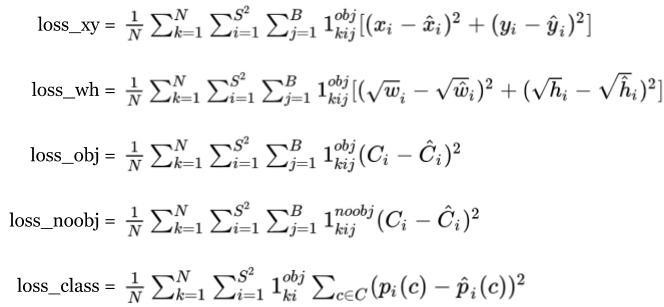

In [ ]:
class Loss(nn.Module):
    def __init__(self, grid_size=7, num_bboxes=2, num_classes=20):
        """ Loss module for Yolo v1.
        Use grid_size, num_bboxes, num_classes information if necessary.

        Args:
            grid_size: (int) size of input grid.
            num_bboxes: (int) number of bboxes per each cell.
            num_classes: (int) number of the object classes.
        """
        super(Loss, self).__init__()
        self.S = grid_size
        self.B = num_bboxes
        self.C = num_classes

    def compute_iou(self, bbox1, bbox2):
        """ Compute the IoU (Intersection over Union) of two set of bboxes, each bbox format: [x1, y1, x2, y2].
        Use this function if necessary.

        Args:
            bbox1: (Tensor) bounding bboxes, sized [N, 4].
            bbox2: (Tensor) bounding bboxes, sized [M, 4].
        Returns:
            (Tensor) IoU, sized [N, M]
        """
        N = bbox1.size(0)
        M = bbox2.size(0)

        # Compute left-top coordinate of the intersections
        lt = torch.max(
            bbox1[:, :2].unsqueeze(1).expand(N, M, 2), # [N, 2] -> [N, 1, 2] -> [N, M, 2]
            bbox2[:, :2].unsqueeze(0).expand(N, M, 2)  # [M, 2] -> [1, M, 2] -> [N, M, 2]
        )
        # Conpute right-bottom coordinate of the intersections
        rb = torch.min(
            bbox1[:, 2:].unsqueeze(1).expand(N, M, 2), # [N, 2] -> [N, 1, 2] -> [N, M, 2]
            bbox2[:, 2:].unsqueeze(0).expand(N, M, 2)  # [M, 2] -> [1, M, 2] -> [N, M, 2]
        )
        # Compute area of the intersections from the coordinates
        wh = rb - lt   # width and height of the intersection, [N, M, 2]
        wh[wh < 0] = 0 # clip at 0
        inter = wh[:, :, 0] * wh[:, :, 1] # [N, M]

        # Compute area of the bboxes
        area1 = (bbox1[:, 2] - bbox1[:, 0]) * (bbox1[:, 3] - bbox1[:, 1]) # [N, ]
        area2 = (bbox2[:, 2] - bbox2[:, 0]) * (bbox2[:, 3] - bbox2[:, 1]) # [M, ]
        area1 = area1.unsqueeze(1).expand_as(inter) # [N, ] -> [N, 1] -> [N, M]
        area2 = area2.unsqueeze(0).expand_as(inter) # [M, ] -> [1, M] -> [N, M]

        # Compute IoU from the areas
        union = area1 + area2 - inter # [N, M, 2]
        iou = inter / union           # [N, M, 2]

        return iou

    def forward(self, pred_tensor, target_tensor):
        """ Compute loss.

        Args:
            pred_tensor (Tensor): predictions, sized [batch_size, S, S, Bx5+C], 5=len([x, y, w, h, conf]).
            target_tensor (Tensor):  targets, sized [batch_size, S, S, Bx5+C].
        Returns:
            loss_xy (Tensor): localization loss for center positions (x, y) of bboxes.
            loss_wh (Tensor): localization loss for width, height of bboxes.
            loss_obj (Tensor): objectness loss.
            loss_noobj (Tensor): no-objectness loss.
            loss_class (Tensor): classification loss.
        """
        # P2. Write your code here
        #############################################################################################################################
        Batch_size = pred_tensor.shape[0]
        coord_mask = target_tensor[:, :, :, 4] == 1 
        noobj_mask = target_tensor[:, :, :, 4] == 0 

        N_object = pred_tensor[coord_mask].shape[0]
        xywh_box1_pred = pred_tensor[coord_mask][:,:4]    
        xywh_box2_pred = pred_tensor[coord_mask][:,5:9]     
        xywh_box1_tar  = target_tensor[coord_mask][:,:4]  
        xywh_box2_tar  = target_tensor[coord_mask][:,5:9] 

        x1y1x2y2_box1_pred = torch.zeros(xywh_box1_pred.size())
        x1y1x2y2_box1_pred[:,  :2] = xywh_box1_pred[:, :2]/float(self.S) - 0.5*xywh_box1_pred[:, 2:4]
        x1y1x2y2_box1_pred[:, 2:4] = xywh_box1_pred[:, :2]/float(self.S) + 0.5*xywh_box1_pred[:, 2:4]

        x1y1x2y2_box2_pred = torch.zeros(xywh_box1_pred.size())
        x1y1x2y2_box2_pred[:,  :2] = xywh_box2_pred[:, :2]/float(self.S) - 0.5*xywh_box2_pred[:, 2:4]
        x1y1x2y2_box2_pred[:, 2:4] = xywh_box2_pred[:, :2]/float(self.S) + 0.5*xywh_box2_pred[:, 2:4] 

        x1y1x2y2_box1_tar = torch.zeros(xywh_box1_pred.size())
        x1y1x2y2_box1_tar[:,  :2] = xywh_box1_tar[:, :2]/float(self.S) - 0.5*xywh_box1_tar[:, 2:4]
        x1y1x2y2_box1_tar[:, 2:4] = xywh_box1_tar[:, :2]/float(self.S) + 0.5*xywh_box1_tar[:, 2:4]

        x1y1x2y2_box2_tar = torch.zeros(xywh_box1_pred.size())
        x1y1x2y2_box2_tar[:,  :2] = xywh_box2_tar[:, :2]/float(self.S) - 0.5*xywh_box2_tar[:, 2:4]
        x1y1x2y2_box2_tar[:, 2:4] = xywh_box2_tar[:, :2]/float(self.S) + 0.5*xywh_box2_tar[:, 2:4]  

        iou_box1 = torch.diagonal(self.compute_iou(x1y1x2y2_box1_pred, x1y1x2y2_box1_tar), 0)
        iou_box2 = torch.diagonal(self.compute_iou(x1y1x2y2_box2_pred, x1y1x2y2_box2_tar), 0)

        iou = torch.cat((iou_box1.reshape(N_object, 1), iou_box2.reshape(N_object, 1)), 1) 
        idx_iou = iou.argmax(1)
        indicator_object = torch.zeros(iou.shape).scatter(1, idx_iou.unsqueeze (1), 1.0) # (N,2)
          
        del x1y1x2y2_box1_pred, x1y1x2y2_box2_pred, x1y1x2y2_box1_tar, x1y1x2y2_box2_tar, iou, idx_iou

        xywh_box1_predtar = torch.cat((xywh_box1_pred, xywh_box1_tar), 1)
        xywh_box2_predtar = torch.cat((xywh_box2_pred, xywh_box2_tar), 1)
        xywh_for_loss = torch.zeros(N_object, 8) # (x,y,w,h,x,y,w,h) for prediction and target where object is detected and has highest IoU

        confidence_box1_predtar = torch.cat((pred_tensor[coord_mask][:,4].reshape(N_object,1), target_tensor[coord_mask][:,4].reshape(N_object,1)), 1)
        confidence_box2_predtar = torch.cat((pred_tensor[coord_mask][:,9].reshape(N_object,1), target_tensor[coord_mask][:,9].reshape(N_object,1)), 1)
        confidence_for_loss = torch.zeros(N_object,2) # (confidence,confidence) for prediction and target where object is detected and has highest IoU

        for i in range(N_object):
          if indicator_object[:,0][i]==1: # box1
            xywh_for_loss[i,:] = xywh_box1_predtar[i,:]
            confidence_for_loss[i,:] = confidence_box1_predtar[i,:]
          else:                           # box2
            xywh_for_loss[i,:] = xywh_box2_predtar[i,:]
            confidence_for_loss[i,:] = confidence_box2_predtar[i,:]
        
        del xywh_box1_predtar, xywh_box2_predtar, confidence_box1_predtar, confidence_box2_predtar, indicator_object
        
        # 1. loss_xy  
        loss_xy = F.mse_loss(xywh_for_loss[:,:2], xywh_for_loss[:,4:6], reduction='sum') / Batch_size

        # 2. loss_wh
        loss_wh = F.mse_loss(torch.sqrt(xywh_for_loss[:,2:4]), torch.sqrt(xywh_for_loss[:,6:]), reduction='sum') / Batch_size
        del xywh_for_loss
        
        # 3. loss_obj 
        loss_obj = F.mse_loss(confidence_for_loss[:,0], confidence_for_loss[:,1], reduction='sum') / Batch_size
        del confidence_for_loss

        # 4. loss_noobj
        loss_noobj = ((F.mse_loss(pred_tensor[noobj_mask][:,4], target_tensor[noobj_mask][:,4], reduction='sum') / Batch_size) +
                     (F.mse_loss(pred_tensor[noobj_mask][:,9], target_tensor[noobj_mask][:,9], reduction='sum') / Batch_size))

        # 5. loss_class 
        loss_class = F.mse_loss(pred_tensor[coord_mask][:,10:], target_tensor[coord_mask][:,10:], reduction='sum') / Batch_size
        
        return loss_xy, loss_wh, loss_obj, loss_noobj, loss_class
        #############################################################################################################################
compute_loss = Loss(grid_size, num_boxes, num_classes)

# Problem 3. Implement Train/Test Pipeline (10pt)

In this section, you need to implement the entire train and test loop in the pipeline.

Specifically, you need to do the followings:
1. set proper device for the inputs (x) / labels (y).
2. feed inputs into the network, get outputs, compute loss using your implemented loss function from problem 2.   
(Don't forget to aggregate them all to calculate a single final loss, using lambda_coord and lambda_noobj).
3. backward the computed loss and update network weights (only in the training loop).

* **Expected training time (for reference)** : About 6 minute / epoch.

In [ ]:
# Training & Testing.
import time 
start_time = time.time()

model = model.to(device)

best_loss = 10 # Initialization of 'best_loss' (loss tends to be less than 10.0)
for epoch in range(1, max_epoch):
    # start time for each train epoch
    _start_time = time.time()   

    # Learning rate scheduling
    if epoch in [50, 150]:
        lr *= 0.1
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    if epoch < last_epoch:
        continue

    model.train()
    train_loss = 0.0  
    step = 0    
    for x, y in train_dloader:
    # P3.1. implement training pipeline here 
        # set proper device for the inputs (x) / labels (y)
        x = x.to(device)
        y = y.to(device) 
        
        # feed inputs into the network and get outputs
        y_pred =  model(x)
        
        # compute loss using your implemented loss function 
        each_loss = compute_loss.forward(y_pred, y) 
        loss = lambda_coord*(each_loss[0]+each_loss[1])+each_loss[2]+lambda_noobj*each_loss[3]+each_loss[4]
        train_loss += loss
        step += 1 

        # flush out the previously computed gradient 
        optimizer.zero_grad()
        
        # backward the computed loss
        loss.backward()  

        # update the network weights
        optimizer.step()
    
    # print train loss, acc, time spent
    train_loss /= float(step)
    t = time.time()-_start_time 
    print(f'Epoch {epoch}/{max_epoch} || train loss={train_loss:.4f} time={t:.3f} secs') 

    # start time for each test epoch
    _start_time = time.time()   

    model.eval()
    test_loss = 0.0
    step = 0
    with torch.no_grad():
        for x, y in test_dloader:
        # P3.2. implement testing pipeline here
          # set proper device for the inputs (x) / labels (y)
          x = x.to(device)
          y = y.to(device)

          # feed inputs into the network and get outputs
          y_pred =  model(x)

          # compute loss using your implemented loss function
          loss = lambda_coord*(each_loss[0]+each_loss[1])+each_loss[2]+lambda_noobj*each_loss[3]+each_loss[4]
          test_loss += loss
          step += 1

    # print test loss, acc, time spent
    test_loss /= float(step)
    t = time.time()-_start_time
    print(f'Epoch {epoch}/{max_epoch} || test loss={test_loss:.4f} time={t:.3f} secs')
 
    if test_loss < best_loss :
      best_loss = test_loss
    ckpt = {'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':epoch}
    torch.save(ckpt, ckpt_path)

# Print final loss with total time spent for training
total_t = time.time()-start_time
print(f'Final best loss : {best_loss:.4f} total time={total_t:.3f} secs')

Epoch 44/50 || train loss=2.9370 time=286.990 secs
Epoch 44/50 || test loss=2.9532 time=30.082 secs
Epoch 45/50 || train loss=2.9220 time=283.455 secs
Epoch 45/50 || test loss=2.5523 time=28.066 secs
Epoch 46/50 || train loss=2.9239 time=273.153 secs
Epoch 46/50 || test loss=2.5609 time=27.497 secs
Epoch 47/50 || train loss=2.9089 time=273.884 secs
Epoch 47/50 || test loss=3.2839 time=27.179 secs
Epoch 48/50 || train loss=2.9030 time=280.255 secs
Epoch 48/50 || test loss=3.1828 time=27.285 secs
Epoch 49/50 || train loss=2.8975 time=285.556 secs
Epoch 49/50 || test loss=3.4643 time=27.408 secs
Final best loss : 2.5523 total time=1878.073 secs


# Problem 4. Implement decoder to extract bounding boxes from output-grids (15pt)


In this section, you need to implement the decoder for extracting bounding boxes from given output grids ($S, S, B \times 5 + 20$). You should complete `decoder` function with given `NMS`(Non Max Suppression) function. 

If you implement it well, you can perform object dection on the given image and get the result through `inference` function.

Check `test_images` directory and find `X_result.jpg` files if you succeeded to run `inference` function, and **attach these files in the discussion section**. 

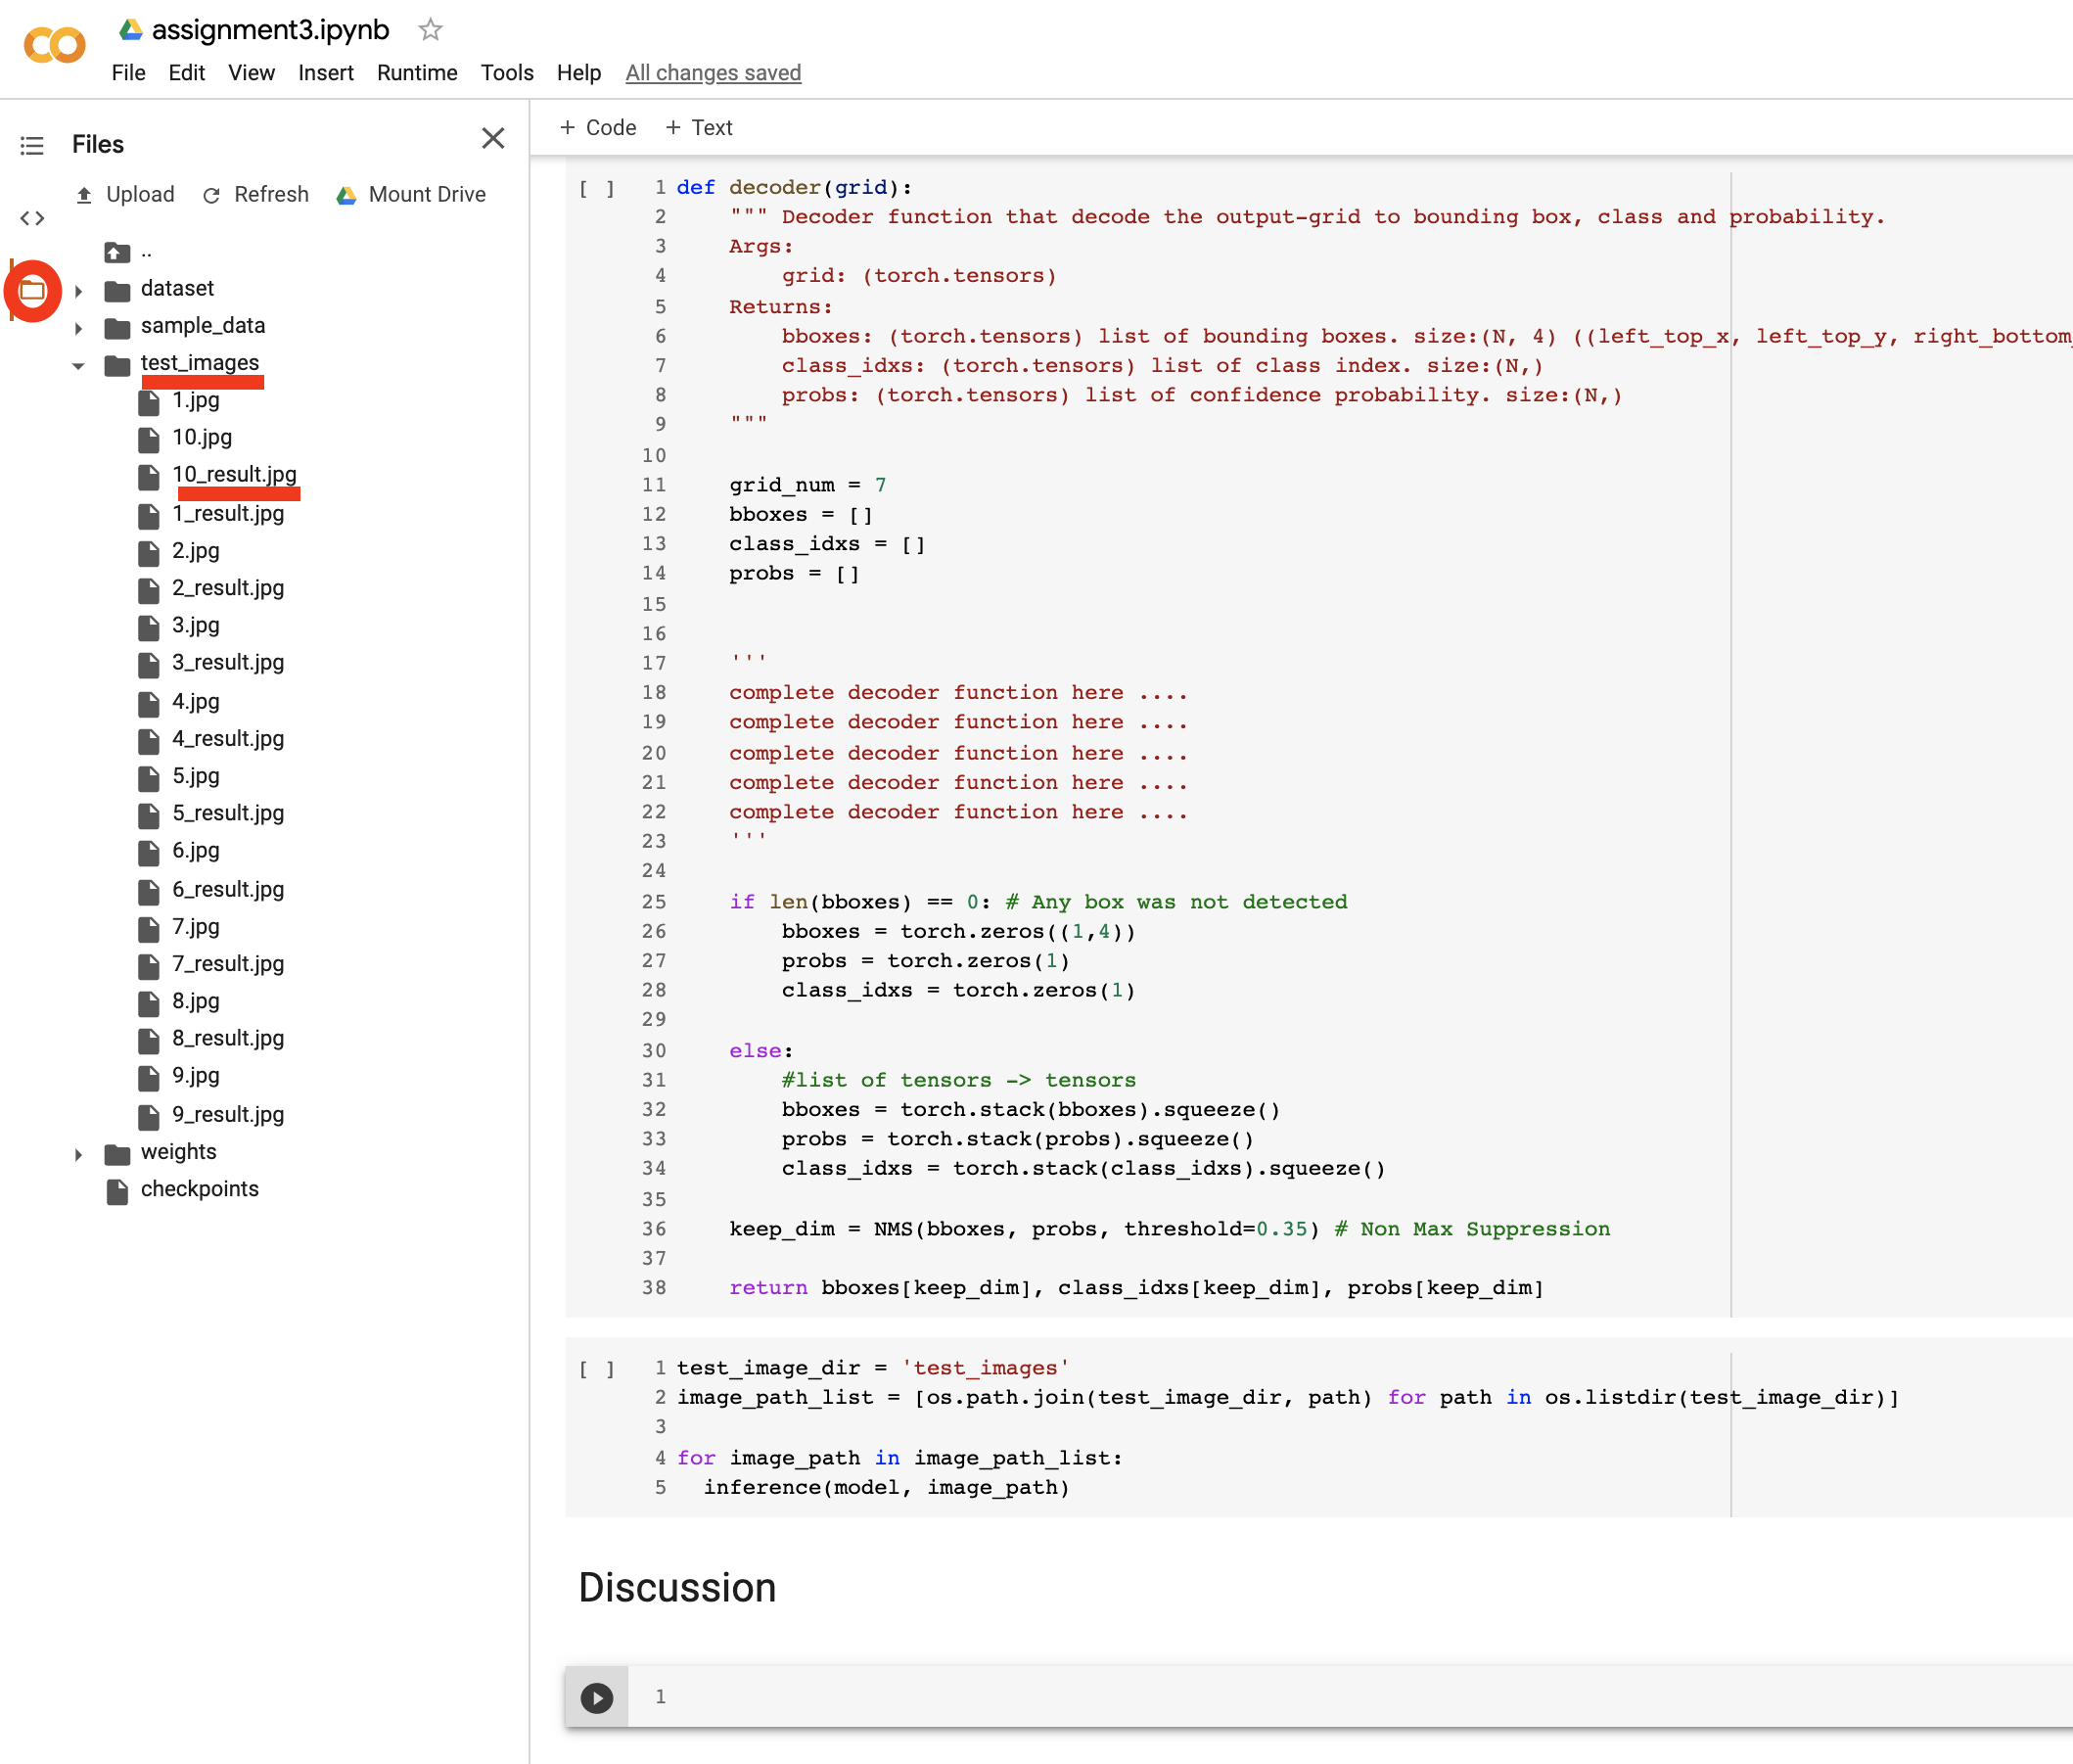

In [8]:
VOC_CLASSES = (
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor')

def NMS(bboxes, scores, threshold=0.35):
    ''' Non Max Suppression
    Args:
        bboxes: (torch.tensors) list of bounding boxes. size:(N, 4) ((left_top_x, left_top_y, right_bottom_x, right_bottom_y), (...))
        probs: (torch.tensors) list of confidence probability. size:(N,) 
        threshold: (float)   
    Returns:
        keep_dim: (torch.tensors)
    '''
    x1 = bboxes[:, 0]
    y1 = bboxes[:, 1]
    x2 = bboxes[:, 2]
    y2 = bboxes[:, 3]

    areas = (x2 - x1) * (y2 - y1)

    _, order = scores.sort(0, descending=True)
    keep = []
    while order.numel() > 0:
        try:
            i = order[0]
        except:
            i = order.item()
        keep.append(i)

        if order.numel() == 1: break

        xx1 = x1[order[1:]].clamp(min=x1[i].item())
        yy1 = y1[order[1:]].clamp(min=y1[i].item())
        xx2 = x2[order[1:]].clamp(max=x2[i].item())
        yy2 = y2[order[1:]].clamp(max=y2[i].item())

        w = (xx2 - xx1).clamp(min=0)
        h = (yy2 - yy1).clamp(min=0)
        inter = w * h

        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        ids = (ovr <= threshold).nonzero().squeeze()
        if ids.numel() == 0:
            break
        order = order[ids + 1]
    keep_dim = torch.LongTensor(keep)
    return keep_dim

In [9]:
def inference(model, image_path):
    """ Inference function
    Args:
        model: (nn.Module) Trained YOLO model.
        image_path: (str) Path for loading the image.
    """
    # load & pre-processing
    image_name = image_path.split('/')[-1]
    image = cv2.imread(image_path)

    h, w, c = image.shape
    img = cv2.resize(image, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img = transform(torch.from_numpy(img).float().div(255).transpose(2, 1).transpose(1, 0)) #Normalization
    img = img.unsqueeze(0)
    img = img.to(device)

    # inference
    output_grid = model(img).cpu()

    #### YOU SHOULD IMPLEMENT FOLLOWING decoder FUNCTION ####
    # decode the output grid to the detected bounding boxes, classes and probabilities.
    bboxes, class_idxs, probs = decoder(output_grid)
    num_bboxes = bboxes.size(0)

    # draw bounding boxes & class name
    for i in range(num_bboxes):
        bbox = bboxes[i]
        class_name = VOC_CLASSES[class_idxs[i]]
        prob = probs[i]

        x1, y1 = int(bbox[0] * w), int(bbox[1] * h)
        x2, y2 = int(bbox[2] * w), int(bbox[3] * h)

        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, '%s: %.2f'%(class_name, prob), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 255), 1,
                    8)

    cv2.imwrite(image_name.replace('.jpg', '_result.jpg'), image)

In [10]:
def decoder(grid):
    """ Decoder function that decode the output-grid to bounding box, class and probability. 
    Args:
        grid: (torch.tensors)
    Returns:
        bboxes: (torch.tensors) list of bounding boxes. size:(N, 4) ((left_top_x, left_top_y, right_bottom_x, right_bottom_y), (...))
        class_idxs: (torch.tensors) list of class index. size:(N,)
        probs: (torch.tensors) list of confidence probability. size:(N,)
    """

    grid_num = 7
    bboxes = []
    class_idxs = []
    probs = []

    # P4 Implement the decoder function 
    #########################################################################################################################
    '''
      Condifence = Pr(Object) * IOU_truth_pred
      Conditional class probability = Pr(Class_i|Object)
      --> Class-specific Confidence = Condifence * Conditional class probability
                                    = Pr(Class_i|Object) * (Pr(Object) * IOU_truth_pred)
    '''
    grid = grid.squeeze(0)
    box_num = 2
    for i in range(grid_num): 
      for j in range(grid_num): 
        class_prob, class_idx = torch.max(grid[j, i, 10:], 0)
        for k in range(box_num): 
          confidence = grid[j, i, 5*k+4] # Condifence = Pr(Object) * IOU_truth_pred
          prob = confidence * class_prob # Class-specific Confidence
          if prob > 0.1: # Set via experiment 
            # x,y,w,h -> x1,y1,x2,y2
            xywh = grid[j, i, 5*k:5*k+4] # center (x,y) with respect to each cell
            grid_ij = torch.FloatTensor([i, j]) * (1.0/float(grid_num)) 
            xy_center = xywh[:2] * (1.0/float(grid_num)) + grid_ij # center (x,y) with respect to whole image
            x1y1x2y2 = torch.FloatTensor(4)
            x1y1x2y2[:2] = xy_center - 0.5*xywh[2:]
            x1y1x2y2[2:] = xy_center + 0.5*xywh[2:]
            
            bboxes.append(x1y1x2y2)
            class_idxs.append(class_idx)
            probs.append(prob)
    #########################################################################################################################                        
    if len(bboxes) == 0: # Any box was not detected
        bboxes = torch.zeros((1,4))
        probs = torch.zeros(1)
        class_idxs = torch.zeros(1, dtype=torch.int)             # for bugs I changed
        
    else: 
        #list of tensors -> tensors
        ## for bugs I changed ##
        ''' # "알 수 없는 이유로 세션이 종료되었습니다."
        print("Check point1")
        bboxes = torch.cat(bboxes, dim=0)
        probs = torch.cat(probs, dim=0)
        class_idxs = torch.cat(class_idxs, dim=0) 
        print("Check point2")
        ''' 
        '''
        bboxes = torch.stack(bboxes, dim=0).squeeze()
        probs = torch.stack(probs, dim=0).squeeze()
        class_idxs = torch.stack(class_idxs, dim=0).squeeze()
        ''' 
        bboxes = torch.stack(bboxes, dim=0)
        probs = torch.stack(probs, dim=0)
        class_idxs = torch.stack(class_idxs, dim=0)

    # Modified version : It applies nms class by class. 
    bboxes_result, class_idxs_result, probs_result = [], [], []
    for label in range(num_classes):
        label_mask = (class_idxs==label)
        if label_mask.sum() > 0:
            _bboxes = bboxes[label_mask]
            _probs = probs[label_mask]
            _class_idxs = class_idxs[label_mask]
            
            keep_dim = NMS(_bboxes, _probs, threshold=0.16) # Non Max Suppression
            bboxes_result.append(_bboxes[keep_dim])
            class_idxs_result.append(_class_idxs[keep_dim])
            probs_result.append(_probs[keep_dim])

    bboxes_result = torch.cat(bboxes_result, 0)
    class_idxs_result = torch.cat(class_idxs_result, 0)
    probs_result = torch.cat(probs_result, 0)

    return bboxes_result, class_idxs_result, probs_result 

In [11]:
test_image_dir = 'test_images'
image_path_list = [os.path.join(test_image_dir, path) for path in os.listdir(test_image_dir)]
model.eval()

for image_path in image_path_list:
  inference(model, image_path)

# Discussion (15pt)
In this section, you should summarize your results with your analysis on them. Since implementation of YOLO is already dense, you don't need to conduct your own experiments this time. Instead, provide a disucssion on YOLO. At least, your discussion must include following items.
* Provide at least 3 result images (`1_image.jpg`, `2_image.jpg`, ...) and brief analysis on them (If it's working well, discuss the key to the success. If it's not working properly, discuss the possible reasons for the failure.) 
* Analysis on why YOLO works so fast compared to its competitors (eg, RCNN, Fast-RCNN, Faster-RCNN). 

**Result Image**

--------------------------------------------------------------------------------------------------

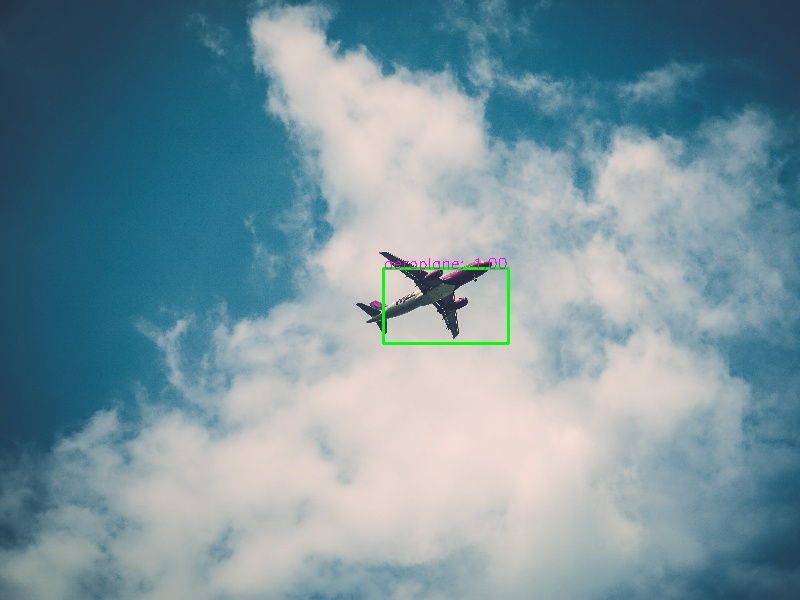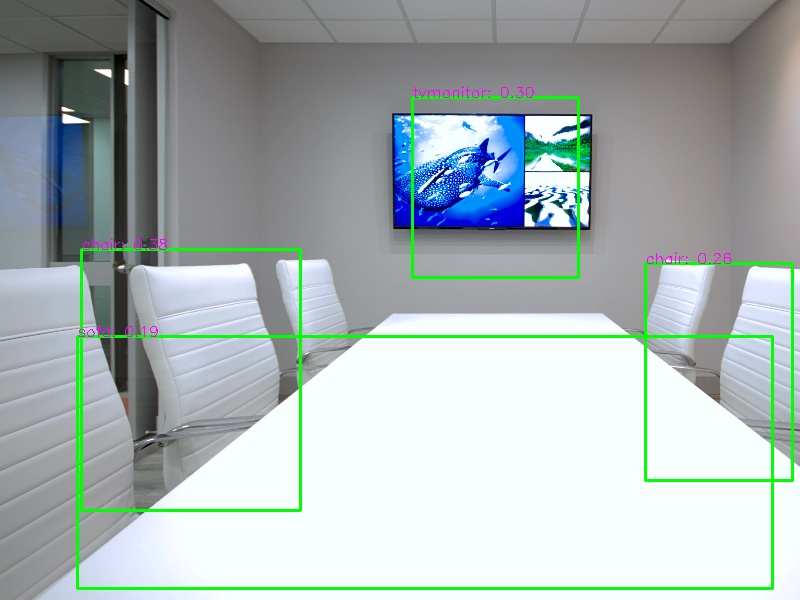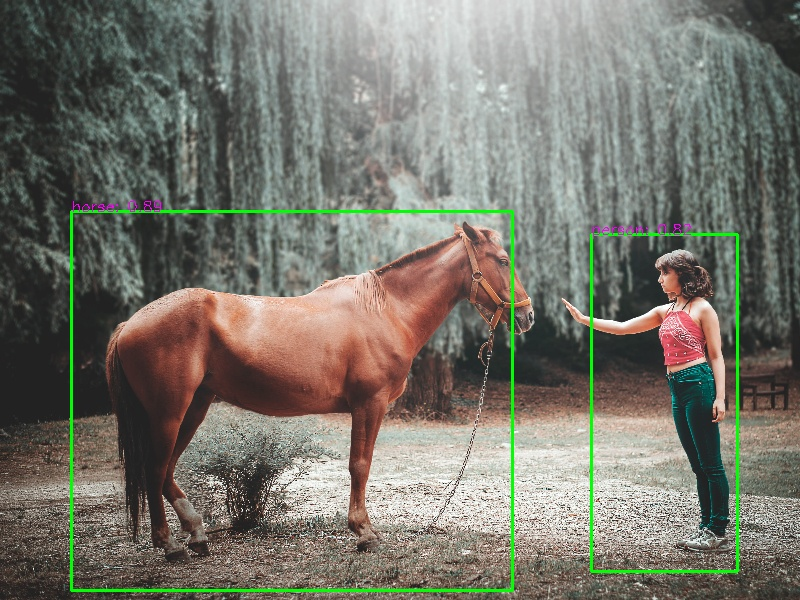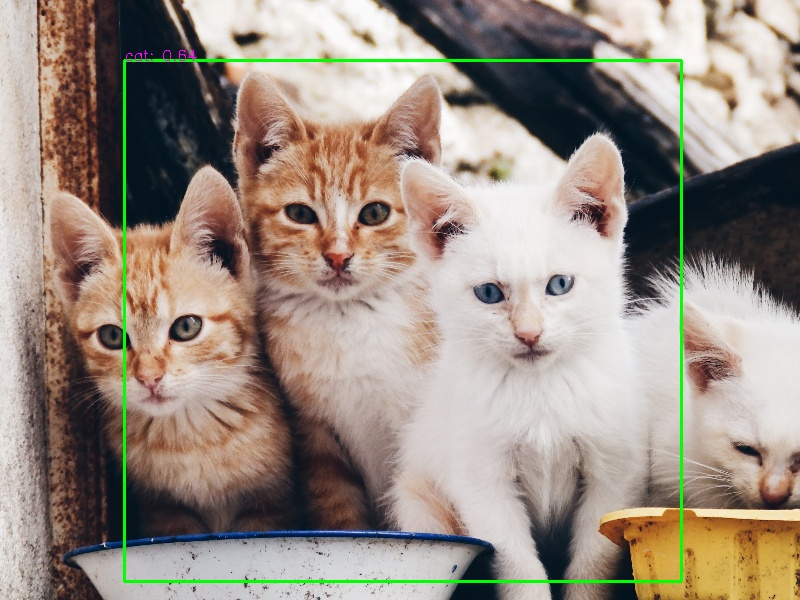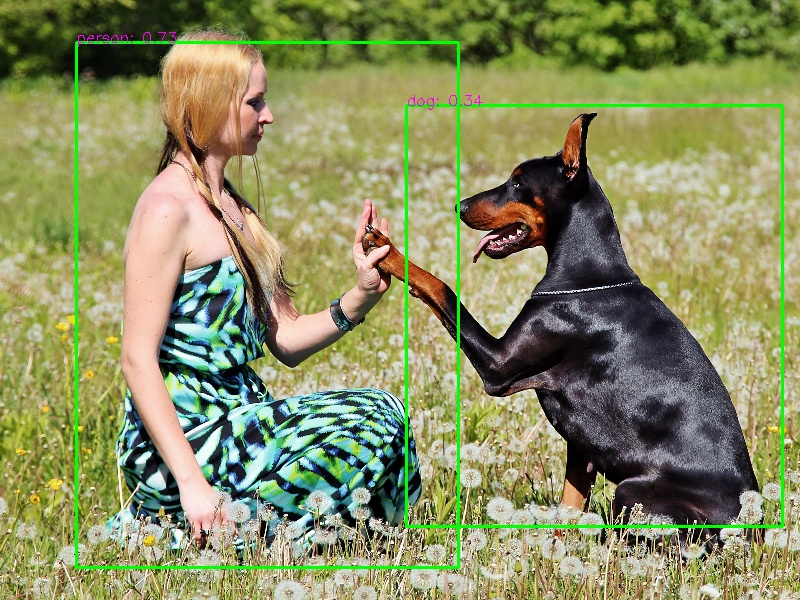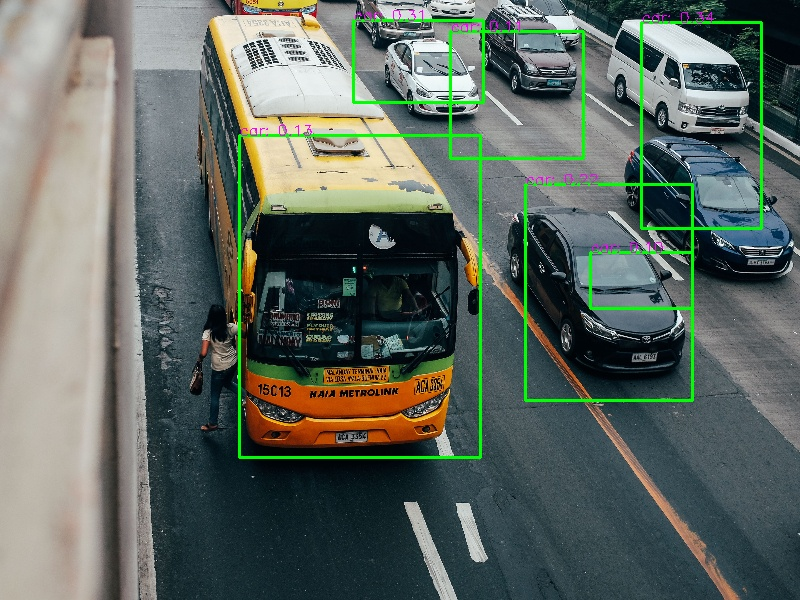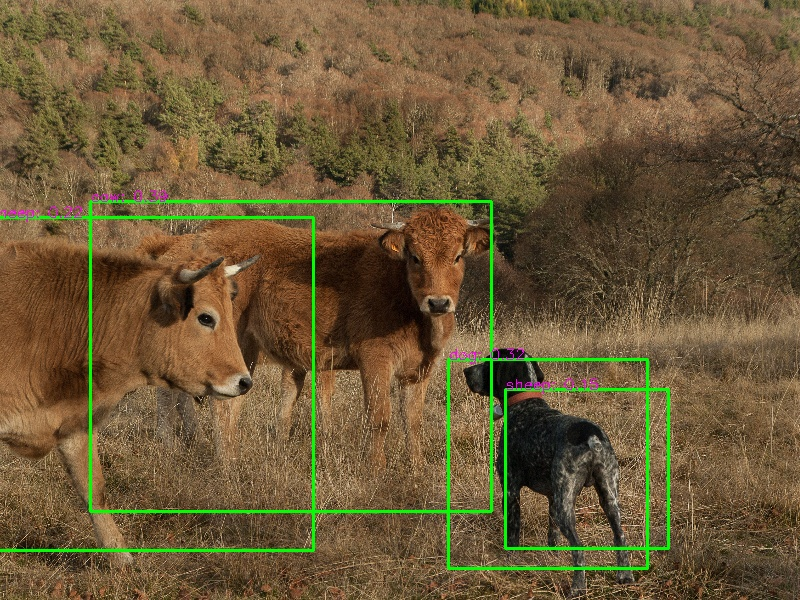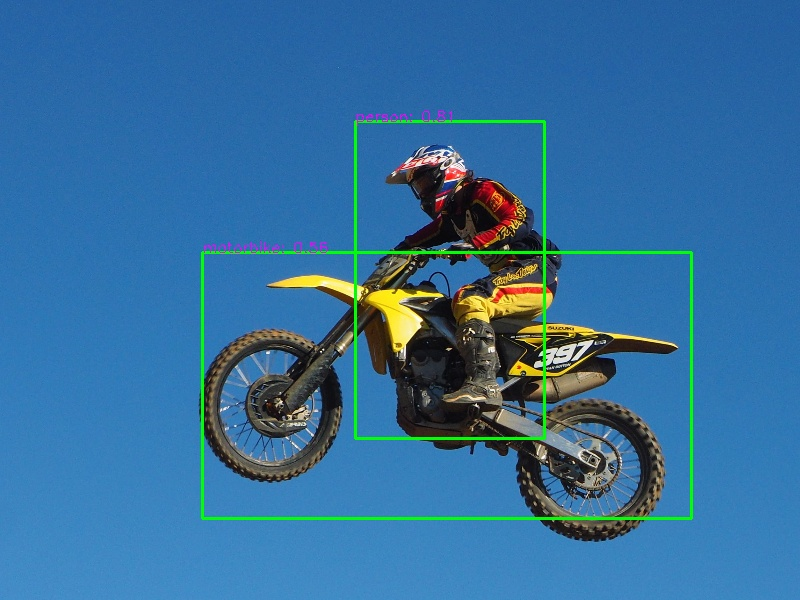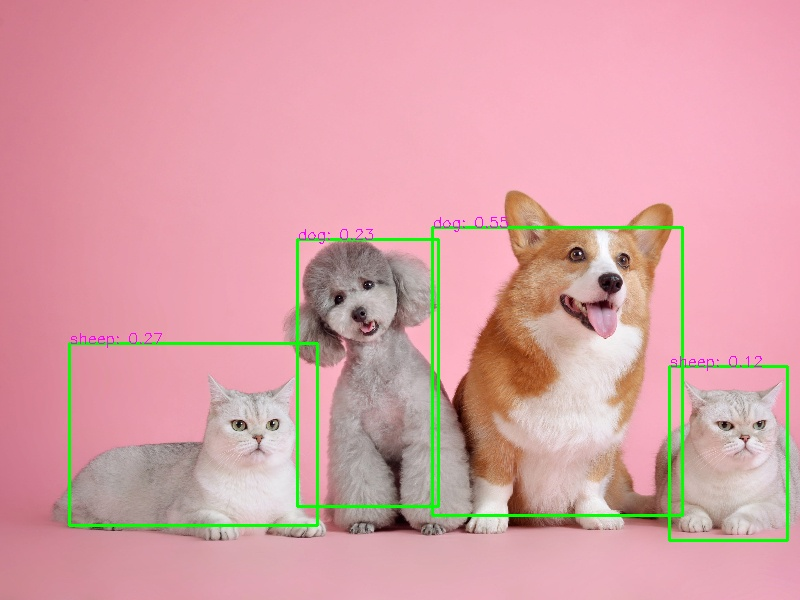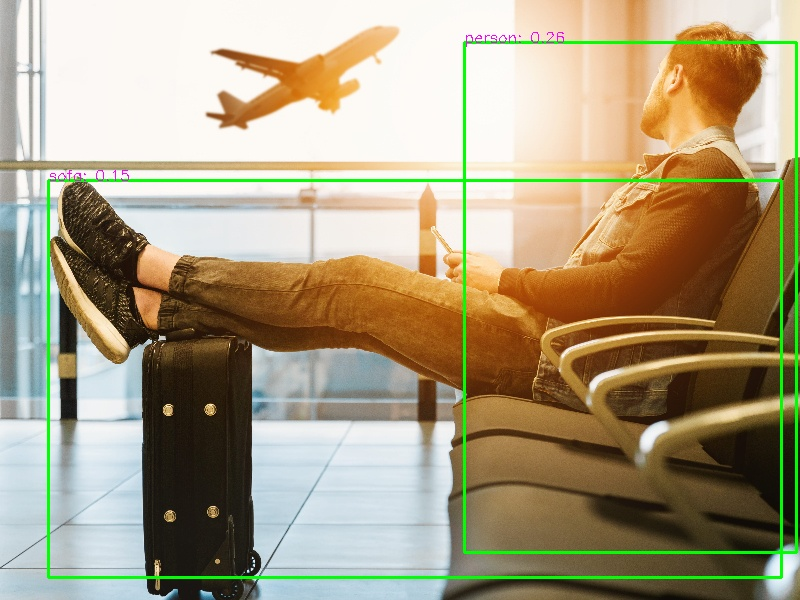

**Code "(x,y): Relative to the bounds of the grid cell --> whole image"**

--------------------------------------------------------------------------------------------------

In [ ]:
'''
    def forward(self, pred_tensor, target_tensor):
        """ Compute loss.

        Args:
            pred_tensor (Tensor): predictions, sized [batch_size, S, S, Bx5+C], 5=len([x, y, w, h, conf]).
            target_tensor (Tensor):  targets, sized [batch_size, S, S, Bx5+C].
        Returns:
            loss_xy (Tensor): localization loss for center positions (x, y) of bboxes.
            loss_wh (Tensor): localization loss for width, height of bboxes.
            loss_obj (Tensor): objectness loss.
            loss_noobj (Tensor): no-objectness loss.
            loss_class (Tensor): classification loss.
        """
        # P2. Write your code here
        #############################################################################################################################
        Batch_size = pred_tensor.shape[0]
        coord_mask = (target_tensor[:, :, :, 4] == 1) 
        noobj_mask = (target_tensor[:, :, :, 4] == 0) 
        N_object = pred_tensor[coord_mask].shape[0] 

        # (x,y) coordinates: the center of the box relative to the bounds of the grid cell
        xywh_box1_pred_grid = pred_tensor[coord_mask][:,:4]    
        xywh_box2_pred_grid = pred_tensor[coord_mask][:,5:9]     
        xywh_box_tar_grid   = target_tensor[coord_mask][:,:4] 

        # (x,y): "relative to the bounds of the grid cell" --> "whole image"
        # (j/7 + y[idx][i][j][0]/7, i/7 + y[idx][i][j][1]/7)
        target_tensor_clone = target_tensor
        pred_tensor_clone   = pred_tensor
        for k in range(Batch_size):
          for i in range(self.S):
            for j in range(self.S): 
              if target_tensor[k,i,j,4] == 1:
                target_tensor_clone[k,i,j,0] = j/7 + target_tensor[k,i,j,0]/7
                target_tensor_clone[k,i,j,1] = i/7 + target_tensor[k,i,j,1]/7
                pred_tensor_clone[k,i,j,0] = j/7 + pred_tensor[k,i,j,0]/7
                pred_tensor_clone[k,i,j,1] = i/7 + pred_tensor[k,i,j,1]/7
                pred_tensor_clone[k,i,j,5] = j/7 + pred_tensor[k,i,j,5]/7
                pred_tensor_clone[k,i,j,6] = i/7 + pred_tensor[k,i,j,6]/7     

        # (x,y) coordinates: the center of the box relative to whole image
        xywh_box1_pred_image = pred_tensor_clone[coord_mask][:,:4]    
        xywh_box2_pred_image = pred_tensor_clone[coord_mask][:,5:9]     
        xywh_box_tar_image   = target_tensor_clone[coord_mask][:,:4]  
        del target_tensor_clone, pred_tensor_clone

        # Get x1y1x2y2
        x1y1x2y2_box1_pred = torch.zeros(xywh_box1_pred_image.size())
        x1y1x2y2_box1_pred[:,  :2] = xywh_box1_pred_image[:, :2] - 0.5*xywh_box1_pred_image[:, 2:4]
        x1y1x2y2_box1_pred[:, 2:4] = xywh_box1_pred_image[:, :2] + 0.5*xywh_box1_pred_image[:, 2:4]

        x1y1x2y2_box2_pred = torch.zeros(xywh_box1_pred_image.size())
        x1y1x2y2_box2_pred[:,  :2] = xywh_box2_pred_image[:, :2] - 0.5*xywh_box2_pred_image[:, 2:4]
        x1y1x2y2_box2_pred[:, 2:4] = xywh_box2_pred_image[:, :2] + 0.5*xywh_box2_pred_image[:, 2:4] 

        x1y1x2y2_box_tar = torch.zeros(xywh_box1_pred_image.size())
        x1y1x2y2_box_tar[:,  :2] = xywh_box_tar_image[:, :2] - 0.5*xywh_box_tar_image[:, 2:4]
        x1y1x2y2_box_tar[:, 2:4] = xywh_box_tar_image[:, :2] + 0.5*xywh_box_tar_image[:, 2:4]

        iou_box1 = torch.diagonal(self.compute_iou(x1y1x2y2_box1_pred, x1y1x2y2_box_tar), 0)
        iou_box2 = torch.diagonal(self.compute_iou(x1y1x2y2_box2_pred, x1y1x2y2_box_tar), 0)

        iou = torch.cat((iou_box1.reshape(N_object, 1), iou_box2.reshape(N_object, 1)), 1) 
        idx_iou = iou.argmax(1)
        indicator_object = torch.zeros(iou.shape).scatter(1, idx_iou.unsqueeze (1), 1.0) # (N,2)         
        del x1y1x2y2_box1_pred, x1y1x2y2_box2_pred, x1y1x2y2_box_tar, iou, idx_iou, xywh_box1_pred_image, xywh_box2_pred_image, xywh_box_tar_image

        xywh_box1_predtar = torch.cat((xywh_box1_pred_grid, xywh_box_tar_grid), 1)
        xywh_box2_predtar = torch.cat((xywh_box2_pred_grid, xywh_box_tar_grid), 1)
        xywh_for_loss = torch.zeros(N_object, 8) # (x,y,w,h,x,y,w,h) for prediction and target where object is detected and has highest IoU
        del xywh_box1_pred_grid, xywh_box2_pred_grid, xywh_box_tar_grid

        confidence_box1_predtar = torch.cat((pred_tensor[coord_mask][:,4].reshape(N_object,1), target_tensor[coord_mask][:,4].reshape(N_object,1)), 1)
        confidence_box2_predtar = torch.cat((pred_tensor[coord_mask][:,9].reshape(N_object,1), target_tensor[coord_mask][:,9].reshape(N_object,1)), 1)
        confidence_for_loss = torch.zeros(N_object,2) # (confidence,confidence) for prediction and target where object is detected and has highest IoU

        for i in range(N_object):
          if indicator_object[:,0][i]==1: # box1
            xywh_for_loss[i,:] = xywh_box1_predtar[i,:]
            confidence_for_loss[i,:] = confidence_box1_predtar[i,:]
          else:                           # box2
            xywh_for_loss[i,:] = xywh_box2_predtar[i,:]
            confidence_for_loss[i,:] = confidence_box2_predtar[i,:]   
        del xywh_box1_predtar, xywh_box2_predtar, confidence_box1_predtar, confidence_box2_predtar, indicator_object
        
        # 1. loss_xy  
        loss_xy = F.mse_loss(xywh_for_loss[:,:2], xywh_for_loss[:,4:6], reduction='sum') / Batch_size

        # 2. loss_wh
        loss_wh = F.mse_loss(torch.sqrt(xywh_for_loss[:,2:4]), torch.sqrt(xywh_for_loss[:,6:]), reduction='sum') / Batch_size
        del xywh_for_loss
        
        # 3. loss_obj 
        loss_obj = F.mse_loss(confidence_for_loss[:,0], confidence_for_loss[:,1], reduction='sum') / Batch_size
        del confidence_for_loss

        # 4. loss_noobj
        loss_noobj = ((F.mse_loss(pred_tensor[noobj_mask][:,4], target_tensor[noobj_mask][:,4], reduction='sum') / Batch_size) +
                     (F.mse_loss(pred_tensor[noobj_mask][:,9], target_tensor[noobj_mask][:,9], reduction='sum') / Batch_size))

        # 5. loss_class 
        loss_class = F.mse_loss(pred_tensor[coord_mask][:,10:], target_tensor[coord_mask][:,10:], reduction='sum') / Batch_size
        
        return loss_xy, loss_wh, loss_obj, loss_noobj, loss_class
        #############################################################################################################################   
'''

**Image about Training Error** on **Code "(x,y): Relative to the bounds of the grid cell --> whole image"**

--------------------------------------------------------------------------------------------------

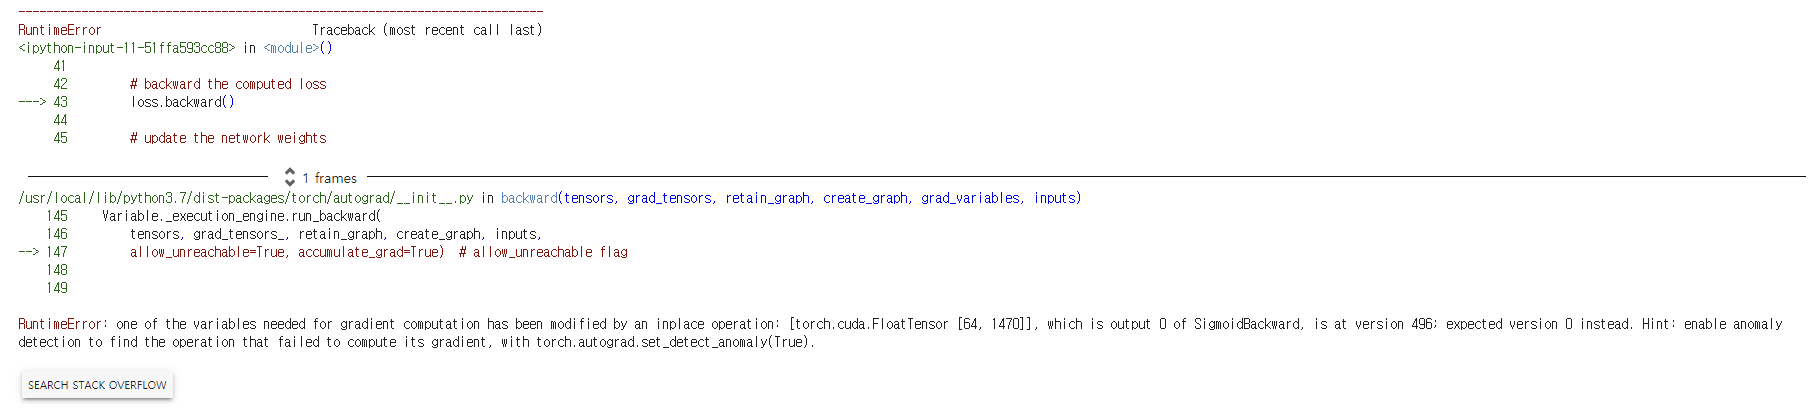

**Image about Example "(x,y): Relative to the bounds of the grid cell --> whole image"**

--------------------------------------------------------------------------------------------------

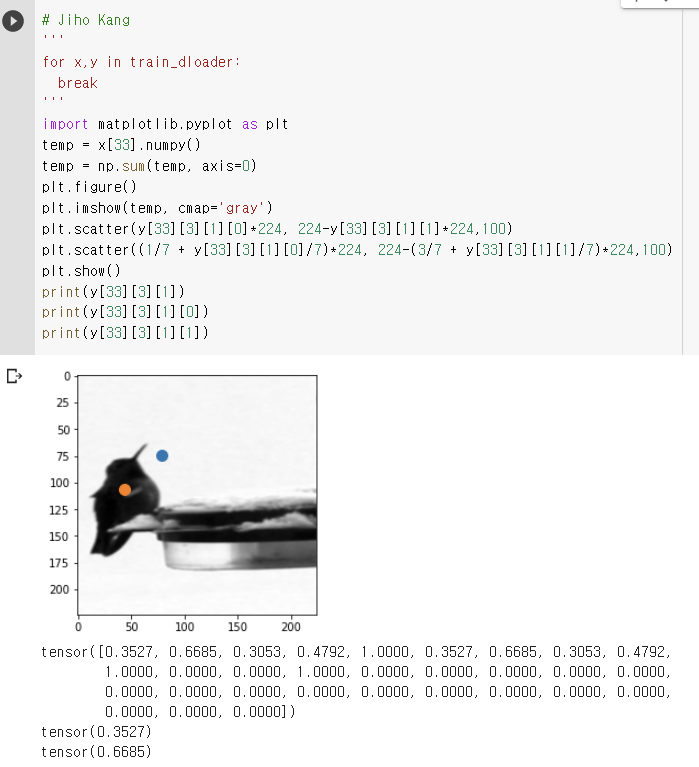

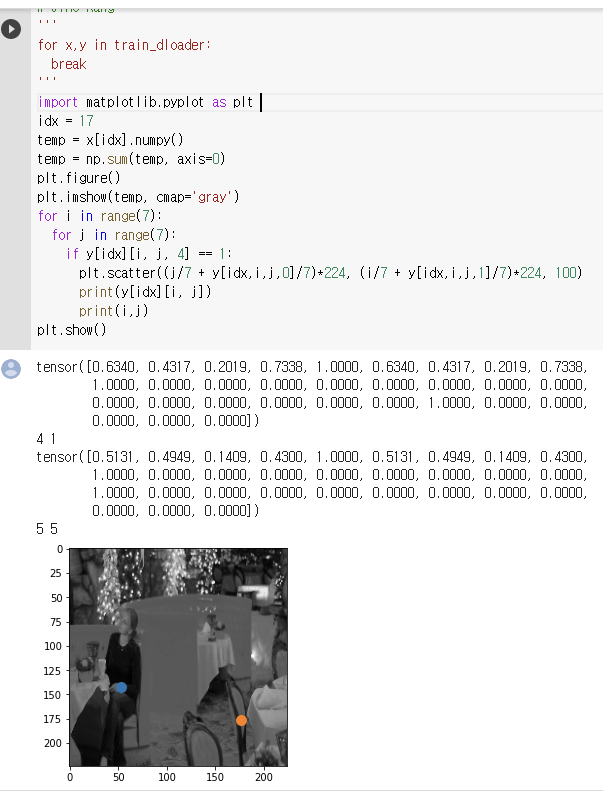

**Discussion** 
--
-------------------------------------------------------------------------------------------------- 
* **Provide at least 3 result images (`1_image.jpg`, `2_image.jpg`, ...) and brief analysis on them (If it's working well, discuss the key to the success. If it's not working properly, discuss the possible reasons for the failure.)** 
 
The original plan was to calculate (x1,y1,x2,y2) after changing **(x,y) for each grid (cell)** to **(x,y) for the whole image**. (Refer to **Code "(x,y): Relative to the bounds of the grid cell --> whole image"**). I implemented the code to find (x1, y1, x2, y2) with respect to (x,y) for the whole image and confirmed that the loss was calculated, but an error continued to occur in the process of "loss.backward()" (backward the computed loss Training), and this could not be resolved(Refer to **Image about Training Error w.r.t Code "(x,y): Relative to the bounds of the grid cell --> whole image"**). 

Training was carried out with the contents implemented in Problem 2 section and the results were confirmed. When the type and number of objects were relatively small in one image, object detection were performed well. However, detection was not good when objects were overlapped or densely arranged at narrow intervals. 
When it comes to good detection results, it can be seen that the loss function is satisfied because the IOU is found appropriately although the calculation process of IOU is not completely correct. The reason for the lack of detail of the bounding box may be due to lack of learning, and it is presumed that the IoU is not completely calculated correctly.

<br/>

* **Analysis on why YOLO works so fast compared to its competitors (eg, RCNN, Fast-RCNN, Faster-RCNN).**

**R-CNN** is an early model based on deep learning for object detection. A region proposal algorithm (selective search) which recommend 2,000 regions in one frame is used to find regions that are likely to contain objects. Then, Proposed regions are normalized to fit the size of 224x224 and inserted into the CNN model to extract features. These features are used to train SVM classifier for each object. In addition, since the proposed region may be different from the real object region, linear regression model to adjust the bounding box is trained. However, image deformation and information loss occur due to normalization, and 2000 regions which are feed into the CNN model cause the amount of computation which is high. To compensate for these limitations of R-CNN, **Fast R-CNN** and **Faster R-CNN** have emerged. However, these algorithm are too slow compared to Yolo in terms of speed. The R-CNN series uses a combination of various preprocessing models and CNN, but YOLO processes them all in a single neural network.

**YOLO** passes the image only once. In other word, YOLO sees the entire image literally only once. This is why yolo is so fast compared to its competitors. It is relatively simpler than other models and can be optimized end-to-end since all processes are performed in one network without additional preprocessing process. This unified architecture can process 45 frames per second in real time and shows pretty good performance in other domains. However, if the objects are too small or overlapping, the prediction may not work properly because only one class is predicted in each grid cell. 

In summary, the R-CNN series is a two-stage detector with separate localization and classification. However, YOLO is a 1-Stage Detector that performs localization and classification at the same time. Yolo has the advantage of being faster because it happens at the same time. 